XGBoost is also known as Extreme Gradient Boosting and is considered to be
Gradient Boosting on steroids. The main advantages of XGBoost over gradient
boosting is speed due to distributed computing, parralelization, out-of-core 
computing and cache optimization. In particular, XGBoost creates trees in
a parralel process while gradient boosting creates trees in a sequential manner.

In [1]:
# First import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import fbeta_score, make_scorer

C:\Users\Leslie\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Import the required datasets
SP500 = pd.read_csv('SP500_2.csv', parse_dates=True)
Nasdaq = pd.read_csv('Nasdaq_2.csv', parse_dates=True)
DJI = pd.read_csv('DJI_2.csv', parse_dates=True)
DAX = pd.read_csv('DAX_2.csv', parse_dates=True)
Paris = pd.read_csv('Paris_2.csv', parse_dates=True)
Tokyo = pd.read_csv('Tokyo_2.csv', parse_dates=True)
HongKong = pd.read_csv('HongKong_2.csv', parse_dates=True)
Aus = pd.read_csv('Aus_2.csv', parse_dates=True)

In [3]:
"""
Since we had previously exported our engineered features as a CSV file,
we can just import it in instead of going through the feature engineering
procedure with our own functions again
"""
reduced_megaset = pd.read_csv('reduced_megaset.csv')

In [4]:
# The target variable is the daily return of each day, binary encoded
target_raw = (SP500['Adj Close'].shift(-1)/SP500['Adj Close'])-1
target = target_raw[21:]
target[target > 0] = 1
target[target <= 0] = 0

In [5]:
# Next, split our dimension_reduced megaset and the target array into training and testing subsets
X_train = reduced_megaset[:6001]
X_test = reduced_megaset[6001:-1]
y_train = target[:6001]
y_test = target[6001:-1]

In [6]:
""" 
XGBClassifier Implementation and Results with parameters at default settings
"""
# call the XGBClassifier and set seed=0 to ensure reproducibility of results
clf_XGB = XGBClassifier(seed = 0)
# fit the clf_XGB on training data
clf_XGB.fit(X_train, y_train)
# make predictions with test data
clf_XGB_predictions = clf_XGB.predict(X_test)
# evaluate predictions with accuracy metric
clf_XGB_accuracy = accuracy_score(y_test, clf_XGB_predictions)
# evaluate predictions with F1-score metric
clf_XGB_f1 = f1_score(y_test, clf_XGB_predictions)
print("XGB Classifier: [Accuracy: {:.4f}, F1-score: {:.4f}]".format(clf_XGB_accuracy, clf_XGB_f1))

XGB Classifier: [Accuracy: 0.5435, F1-score: 0.6809]


In [7]:
"""
The results above is not the best it could be. The XGBoost model can evaluate
and report on the performance on a cross-validation set for the model during
training.

For this, we need to split our dimension-reduced megaset and the target array 
into training, cross-validation and testing subsets
"""
X_train = reduced_megaset[:5401]
X_cv = reduced_megaset[5401:6001]
X_test = reduced_megaset[6001:-1]
y_train = target[:5401]
y_cv = target[5401:6001]
y_test = target[6001:-1]

print("we now have {} training data, {} cross-validation data and {} testing data.".format(X_train.shape[0], 
                                                                                           X_cv.shape[0], X_test.shape[0]))

we now have 5401 training data, 600 cross-validation data and 230 testing data.


In [8]:
""" 
XGBClassifier Implementation with Performance Monitoring using error metric on cross-validation set
"""
# defining our evaluation set (cross-validation)
eval_set = [(X_cv, y_cv)]
# notice eval_set is now defined in the training parameters and verbose set to True
clf_XGB.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
clf_XGB_predictions = clf_XGB.predict(X_test)
clf_XGB_accuracy = accuracy_score(y_test, clf_XGB_predictions)
clf_XGB_f1 = f1_score(y_test, clf_XGB_predictions)
print("Improved XGB Classifier: [Accuracy: {:.4f}, f1-score: {:.4f}]".format(clf_XGB_accuracy, clf_XGB_f1))

[0]	validation_0-error:0.505
[1]	validation_0-error:0.515
[2]	validation_0-error:0.51
[3]	validation_0-error:0.491667
[4]	validation_0-error:0.48
[5]	validation_0-error:0.5
[6]	validation_0-error:0.491667
[7]	validation_0-error:0.49
[8]	validation_0-error:0.483333
[9]	validation_0-error:0.501667
[10]	validation_0-error:0.506667
[11]	validation_0-error:0.483333
[12]	validation_0-error:0.485
[13]	validation_0-error:0.491667
[14]	validation_0-error:0.5
[15]	validation_0-error:0.496667
[16]	validation_0-error:0.501667
[17]	validation_0-error:0.498333
[18]	validation_0-error:0.498333
[19]	validation_0-error:0.495
[20]	validation_0-error:0.496667
[21]	validation_0-error:0.5
[22]	validation_0-error:0.503333
[23]	validation_0-error:0.501667
[24]	validation_0-error:0.505
[25]	validation_0-error:0.503333
[26]	validation_0-error:0.506667
[27]	validation_0-error:0.508333
[28]	validation_0-error:0.511667
[29]	validation_0-error:0.511667
[30]	validation_0-error:0.506667
[31]	validation_0-error:0.51


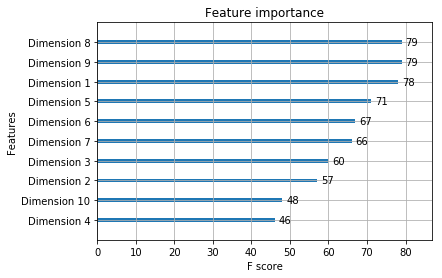

[ 0.11981567  0.08755761  0.0921659   0.07066052  0.10906298  0.10291859
  0.10138249  0.12135176  0.12135176  0.07373272]


In [9]:
""" 
Feature importance with XGBoost.
One of the many benefits of using XGBoost is that it can automatically provide estimates of feature importance from a trained
predictive model.
"""
# calculates the importance of each feature in the training data
plot_importance(clf_XGB)
plt.show()
print(clf_XGB.feature_importances_)

In [10]:
"""
Optimization of XGBClassifier.
Finally, let's try to optimise the performance of our XGBoost model using GridSearch() with a cross-validation set generated
from TimeSeriesSplit(). 
"""
# resetting our training data as we are now going to use TimeSeriesSplit to make cross-validation
X_train = reduced_megaset[:6001]
X_test = reduced_megaset[6001:-1]
y_train = target[:6001]
y_test = target[6001:-1]
# Choose the time series cross-validator
tscv = TimeSeriesSplit(n_splits=3)
# Choose XGB Classifier as the algorithm for optimization with GridSearch
clf_XGB2 = XGBClassifier(objective = 'binary:logistic', seed = 0)
# Create a dictionary for the parameters
parameters_XGB = {'n_estimators':[115, 120, 125], 
                  'learning_rate':[0.005, 0.006, 0.007],
                  'max_depth':[1, 2, 3],
                  'subsample':[0.85, 0.9, 0.95],
                  'gamma':[5, 10, 15],
                  'colsample_bytree':[0.3, 0.5, 0.7],
                  'reg_lambda':[0, 1]}
# Define a scoring function
scorer = make_scorer(f1_score)
# Create the GridSearch object"""
grid_obj_XGB = GridSearchCV(estimator=clf_XGB2, param_grid=parameters_XGB, scoring=scorer, cv=tscv)
# Fit the grid search object to the data to compute the optimal model
grid_fit_XGB = grid_obj_XGB.fit(X_train, y_train)
# Return the optimal model after fitting the data
best_clf_XGB = grid_fit_XGB.best_estimator_
# Make predictions with the optimal model
best_predictions_XGB = best_clf_XGB.predict(X_test)
# Get the accuracy and F1_score of the optimized model
clf_XGB2_optimized_accuracy = accuracy_score(y_test, best_predictions_XGB)
clf_XGB2_optimized_f1 = f1_score(y_test, best_predictions_XGB)
print("XGB Classifier Optimized [Accuracy score: {:.4f}, f1-score: {:.4f}]".format(clf_XGB2_optimized_accuracy, 
                                                                                   clf_XGB2_optimized_f1))

XGB Classifier Optimized [Accuracy score: 0.5826, f1-score: 0.7363]


XGB Classifier: [Accuracy: 0.5435, F1-score: 0.6809]
Improved XGB Classifier: [Accuracy: 0.5739, f1-score: 0.7168]
XGB Classifier Optimized [Accuracy score: 0.5826, f1-score: 0.7363]